## **Ismail** **Olumegbon**

# Final Project
## Analysis the co-variation of CDNC and aerosol in the east coast of U.S.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import netCDF4
import datetime
!pip install --no-binary shapely shapely --force
!pip install cartopy
import cartopy.crs as ccrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.0.tar.gz (274 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached Shapely-1.8.5.post1.tar.gz (200 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.5.post1-cp38-cp38-linux_x86_64.whl size=755459 sha256=4f24595240d5e77702cbf326e524c63a561b5e235e0a64b587ac2ca10eb2f7bd
  Stored in directory: /root/.cache/pip/wheels/1e/b7/86/5badb596b4dcdcb8f0fa49a4b83e7d934681843c6dc406b16d
Successfully built shapely
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.

## read in the CDNC data from Bennartz and Rausch dataset

The file /content/drive/Shareddrives/PHYS640-440/Data/cdnc_climatology.nc
contains the cloud droplet number concentration (CDNC) drived from satellite observations based on the study

*Bennartz, R. and Rausch, J., 2017: Global and regional estimates of warm cloud droplet number concentration based on 13 years of AQUA-MODIS observations, Atmos. Chem. Phys., 17, 9815-9836, https://doi.org/10.5194/acp-17-9815-2017, 2017.*


In [ ]:
class Bennartz_CDNC():
    def __init__(self,filename):
        from netCDF4 import Dataset
        import datetime
        nc_fid = Dataset(filename, 'r')
        nc_fid.set_auto_mask(False)
        self.t0   = datetime.datetime(1950,1,1)
        self.time = nc_fid.variables['time'][:]
        days = []
        for t in self.time:
            days.append(self.t0 +  datetime.timedelta(t))
        self.days = days
        self.lon  = nc_fid.variables['lon'][:] #* units('degree_E')
        self.lat  = nc_fid.variables['lat'][:] #* units('degree_N')
        self.cdnc = nc_fid.variables['CDNC'][:] #* units('cm^-3')
        self.cdnc[self.cdnc<0.0] = np.NAN
Bennartz_CDNC_file='/content/drive/Shareddrives/ZZhang_Teaching/Data/cdnc_climatology.nc'
CDNC = Bennartz_CDNC(Bennartz_CDNC_file)

## plot the map of annual mean CDNC using the package [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)

<ipython-input-4-c56fa5ec7b59>:7: RuntimeWarning: Mean of empty slice
  cf=ax.pcolormesh(CDNC.lon,CDNC.lat,np.nanmean(CDNC.cdnc,axis=0),
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<__array_function__ internals>:5: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/numpy/lib

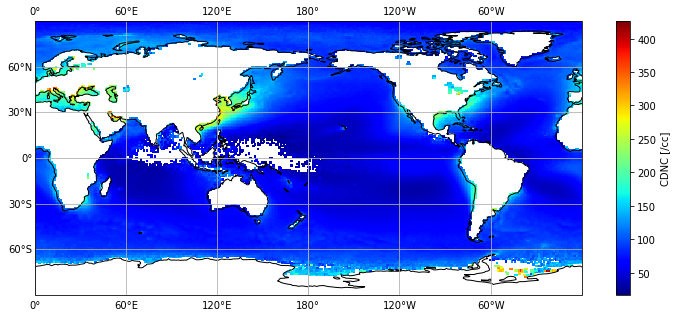

In [ ]:
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(1, 1, figsize=(12,8),
                       subplot_kw={'projection': proj})
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
cf=ax.pcolormesh(CDNC.lon,CDNC.lat,np.nanmean(CDNC.cdnc,axis=0),
              transform=ccrs.PlateCarree(),
              cmap='jet')
fig.subplots_adjust(hspace=0, wspace=0, top=0.6, left=0.1)

plt.colorbar(cf,ax=ax,label='CDNC [/cc]')
def resize_colobar(event):
    plt.draw()
    posn = ax.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])
fig.canvas.mpl_connect('resize_event', resize_colobar)
plt.show()

## read in the aerosol data from [MERRA-2 reanalysis data](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)

The Modern-Era Retrospective analysis for Research and Applications, Version 2 (MERRA-2) provides data beginning in 1980. It was introduced to replace the original MERRA dataset because of the advances made in the assimilation system that enable assimilation of modern hyperspectral radiance and microwave observations, along with GPS-Radio Occultation datasets. It also uses NASA's ozone profile observations that began in late 2004. Additional advances in both the GEOS model and the GSI assimilation system are included in MERRA-2. Spatial resolution remains about the same (about 50 km in the latitudinal direction) as in MERRA.

Along with the enhancements in the meteorological assimilation, MERRA-2 takes some significant steps towards GMAO’s target of an Earth System reanalysis. MERRA-2 is the first long-term global reanalysis to assimilate space-based observations of aerosols and represent their interactions with other physical processes in the climate system. MERRA-2 includes a representation of ice sheets over (say) Greenland and Antarctica.

### define the MERRA-2 aerosol product and read in all files (this step takes some time ~ a few minutes)

In [ ]:
class Merra2_Aerosol():
    def __init__(self):
        from netCDF4 import Dataset
        import datetime
        import os
        dp = r'/content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/'
        allfiles=sorted(os.listdir(dp))
        nfile = 0
        self.month=[]
        for fname in allfiles:
          fn = os.path.join(dp,fname)
          print('processing',fn)
          nfile += 1
          nc_fid = Dataset(fn, 'r')
          nc_fid.set_auto_mask(False)
          p0=fn.find('.nc4')
          self.month.append(datetime.date(int(fn[p0-6:p0-2]),int(fn[p0-2:p0]),15))
          BC = (nc_fid.variables['BCSMASS'][:]) #* units('kg m^-3')
          OC = (nc_fid.variables['OCSMASS'][:]) #* units('kg m^-3')
          DMS = (nc_fid.variables['DMSSMASS'][:]) #* units('kg m^-3')
          DU = (nc_fid.variables['DUSMASS'][:]) #* units('kg m^-3')
          SO4 = (nc_fid.variables['SO4SMASS'][:]) #* units('kg m^-3')
          SS = (nc_fid.variables['SSSMASS'][:]) #* units('kg m^-3')

          if nfile ==1:
            self.lon  = nc_fid.variables['lon'][:] #* units('degree_E')
            self.lat  = nc_fid.variables['lat'][:] #* units('degree_N')
          self.BC = BC if nfile ==1 else np.concatenate((self.BC,BC),axis=0)
          self.OC = OC if nfile ==1 else np.concatenate((self.OC,OC),axis=0)
          self.DMS = DMS if nfile ==1 else np.concatenate((self.DMS,DMS),axis=0)
          self.DU = DU if nfile ==1 else np.concatenate((self.DU,DU),axis=0)
          self.SO4 = SO4 if nfile ==1 else np.concatenate((self.SO4,SO4),axis=0)
          self.SS = SS if nfile ==1 else np.concatenate((self.SS,SS),axis=0)
          print(self.SO4.shape)
aerosol = Merra2_Aerosol()

processing /content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/MERRA2_300.tavgM_2d_aer_Nx.200301.nc4
(1, 361, 576)
processing /content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/MERRA2_300.tavgM_2d_aer_Nx.200302.nc4
(2, 361, 576)
processing /content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/MERRA2_300.tavgM_2d_aer_Nx.200303.nc4
(3, 361, 576)
processing /content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/MERRA2_300.tavgM_2d_aer_Nx.200304.nc4
(4, 361, 576)
processing /content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/MERRA2_300.tavgM_2d_aer_Nx.200305.nc4
(5, 361, 576)
processing /content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/MERRA2_300.tavgM_2d_aer_Nx.200306.nc4
(6, 361, 576)
processing /content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/MERRA2_300.tavgM_2d_aer_Nx.200307.nc4
(7, 361, 576)
processing /content/drive/Shareddrives/ZZhang_Teaching/Data/MERRA2-Aerosols/MERRA2_300.tavgM_2d_aer_Nx.2

In [ ]:
# print the dimentions of the MERRA-2 data
print('Merra-2 latitude size', aerosol.lat.size)
print('Merra-2 longitude size', aerosol.lon.size)
print('Merra-2 time step', len(aerosol.month))
print('CDNC lat lon sizes',len(CDNC.lat),len(CDNC.lon))
print('CDNC data time step',len(CDNC.days))

Merra-2 latitude size 361
Merra-2 longitude size 576
Merra-2 time step 156
CDNC lat lon sizes 180 360
CDNC data time step 156


### The MERRA-2 aerosol reanalysis product provides the simulation of 6 types of aerosols in the unit of [kg / m^3]


*   Sulfate (SO4)
*   Dust
*   Black Carbon
*   Organic Carbon
*   Sea Salt
*   DMS (Dimethyl sulfide)


Below we plot the surface concentration of these aerosols


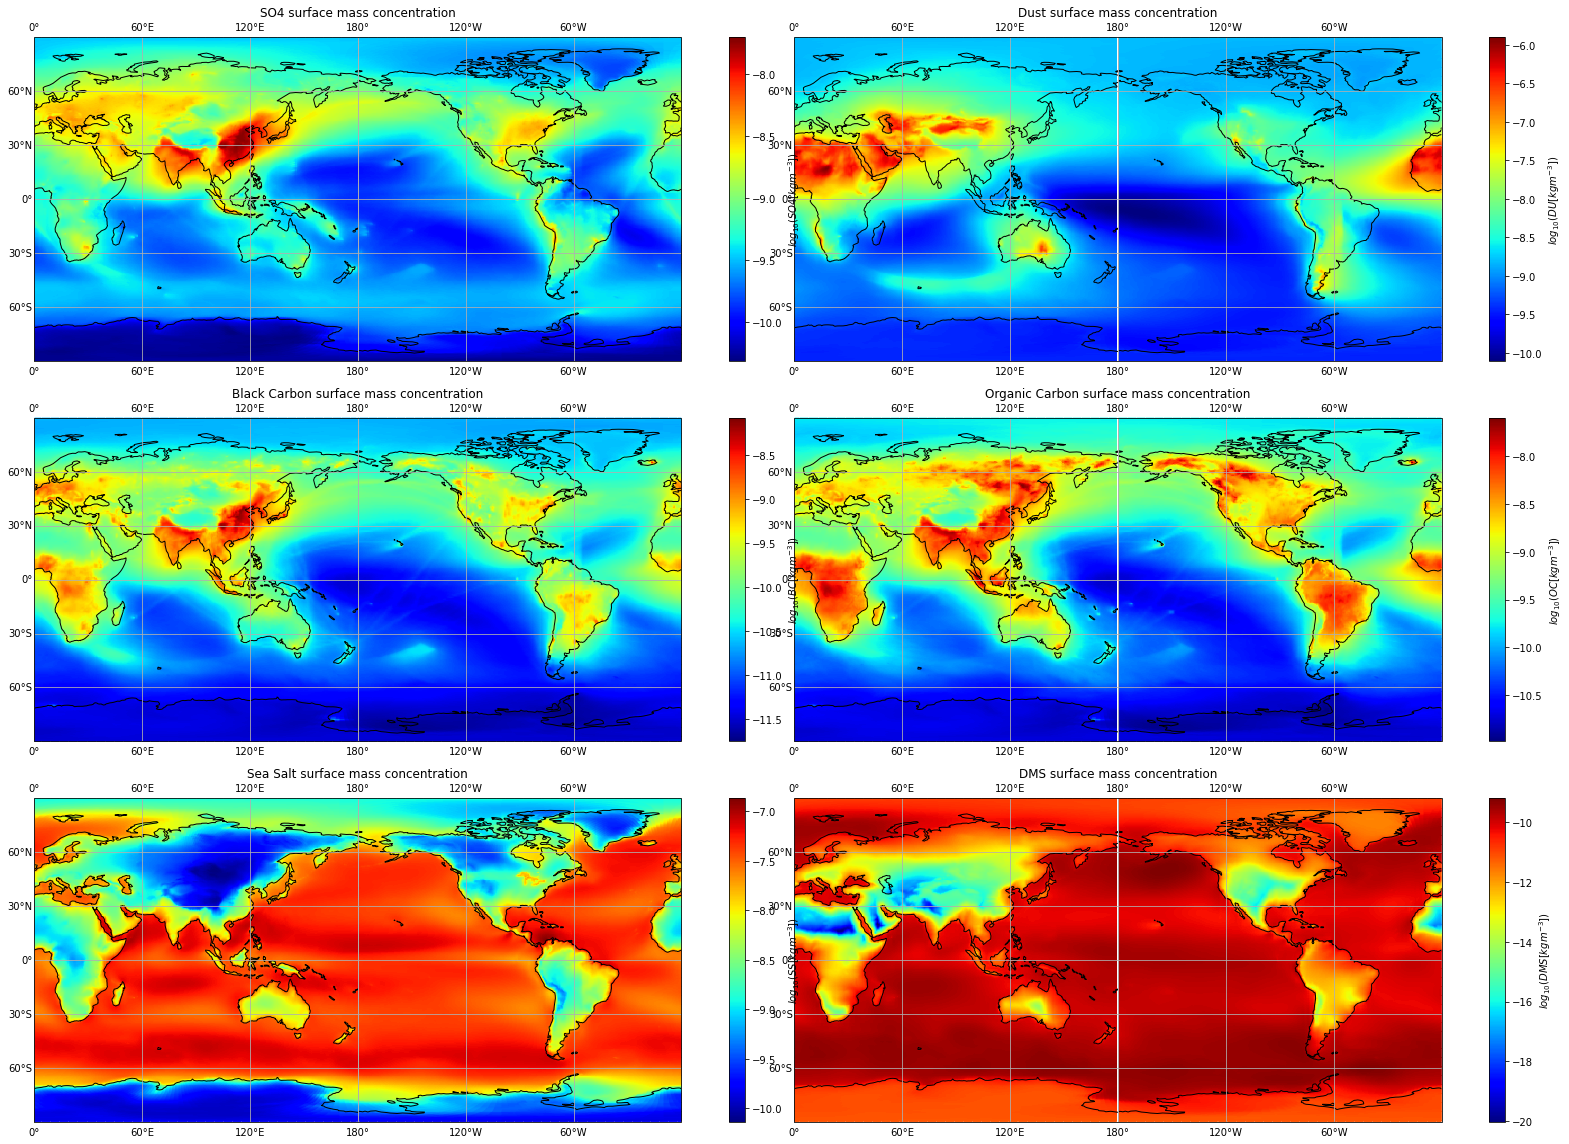

In [ ]:
proj = ccrs.PlateCarree(central_longitude=180)
fig, axs = plt.subplots(3, 2, figsize=(24,16),
                       subplot_kw={'projection': proj},
                        tight_layout=True)
for ax in axs.ravel():
  ax.set_global()
  ax.coastlines()
  ax.gridlines(draw_labels=True)
cf1=axs[0,0].pcolormesh(aerosol.lon,aerosol.lat,np.log10(aerosol.SO4.mean(axis=0)),
              transform=ccrs.PlateCarree(),
              cmap='jet')
axs[0,0].set_title('SO4 surface mass concentration')
fig.subplots_adjust(hspace=0, wspace=0, top=0.6, left=0.1)
plt.colorbar(cf1,ax=axs[0,0],label=r'$log_{10}(SO4 [kg m^{-3}])$')

cf2=axs[0,1].pcolormesh(aerosol.lon,aerosol.lat,np.log10(aerosol.DU.mean(axis=0)),
              transform=ccrs.PlateCarree(),
              cmap='jet')
axs[0,1].set_title('Dust surface mass concentration')
fig.subplots_adjust(hspace=0, wspace=0, top=0.6, left=0.1)
plt.colorbar(cf2,ax=axs[0,1],label=r'$log_{10}(DU [kg m^{-3}])$')

cf3=axs[1,0].pcolormesh(aerosol.lon,aerosol.lat,np.log10(aerosol.BC.mean(axis=0)),
              transform=ccrs.PlateCarree(),
              cmap='jet')
axs[1,0].set_title('Black Carbon surface mass concentration')
fig.subplots_adjust(hspace=0, wspace=0, top=0.6, left=0.1)
plt.colorbar(cf3,ax=axs[1,0],label=r'$log_{10}(BC [kg m^{-3}])$')


cf4=axs[1,1].pcolormesh(aerosol.lon,aerosol.lat,np.log10(aerosol.OC.mean(axis=0)),
              transform=ccrs.PlateCarree(),
              cmap='jet')
axs[1,1].set_title('Organic Carbon surface mass concentration')
fig.subplots_adjust(hspace=0, wspace=0, top=0.6, left=0.1)
plt.colorbar(cf4,ax=axs[1,1],label=r'$log_{10}(OC [kg m^{-3}])$')


cf5=axs[2,0].pcolormesh(aerosol.lon,aerosol.lat,np.log10(aerosol.SS.mean(axis=0)),
              transform=ccrs.PlateCarree(),
              cmap='jet')
axs[2,0].set_title('Sea Salt surface mass concentration')
fig.subplots_adjust(hspace=0, wspace=0, top=0.6, left=0.1)
plt.colorbar(cf5,ax=axs[2,0],label=r'$log_{10}(SS [kg m^{-3}])$')


cf6=axs[2,1].pcolormesh(aerosol.lon,aerosol.lat,np.log10(aerosol.DMS.mean(axis=0)),
              transform=ccrs.PlateCarree(),
              cmap='jet')
axs[2,1].set_title('DMS surface mass concentration')
fig.subplots_adjust(hspace=0, wspace=0, top=0.6, left=0.1)
plt.colorbar(cf6,ax=axs[2,1],label=r'$log_{10}(DMS [kg m^{-3}])$')

fig.canvas.mpl_connect('resize_event', resize_colobar)
plt.show()

## Investigate the potential covariations between the CDNC and aerosols

In [ ]:
# print the dimentions of the MERRA-2 data
print('Merra-2 latitude size', aerosol.lat.size)
print('Merra-2 longitude size', aerosol.lon.size)
print('Merra-2 time step', len(aerosol.month))
print('CDNC lat lon sizes',len(CDNC.lat),len(CDNC.lon))
print('CDNC data time step',len(CDNC.days))

Merra-2 latitude size 361
Merra-2 longitude size 576
Merra-2 time step 156
CDNC lat lon sizes 180 360
CDNC data time step 156


### Task 1 [30 points]


*   derive the annual cycle of CDNC in the east coast of the U.S.
*   derive the annual cycle of the surface concentration of each aerosol type (in log10 space)
*   Do you see any potential correlation between the annual cycle of CDNC and those of aerosols?




In [ ]:
east_lat = (CDNC.lat >25) & (CDNC.lat<45)
east_lon = (CDNC.lon >360-80) & (CDNC.lon<360-50)
cdnc_east = CDNC.cdnc[:,east_lat,:][:,:,east_lon]
cdnc_mean = np.nanmean(cdnc_east,axis=(1,2)) # Compute the arithmetic mean along the lats and lon while ignoring NaNs
annual_cdnc = cdnc_mean.reshape(13,12).T #12*13 = 156, the data time step

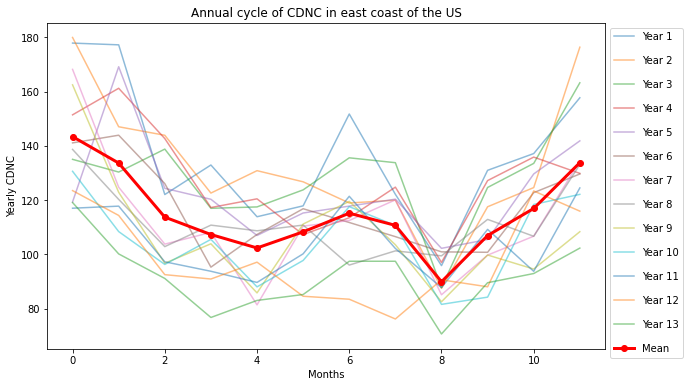

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(0,13):
  ax.plot(annual_cdnc[:,i], label="Year "+str(i+1), alpha =0.5)
ax.plot(np.mean(annual_cdnc, axis=(1)), 'ro-', lw = 3, label = 'Mean')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best', labelspacing=1.4, bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("Months")
ax.set_ylabel("Yearly CDNC")
ax.set_title("Annual cycle of CDNC in east coast of the US")
plt.show()

In [ ]:
east_aero_lat = (aerosol.lat >25) & (aerosol.lat<45)
east_aero_lon = (aerosol.lon >-85) & (aerosol.lon<-60)
aerosol_bcarbon = aerosol.BC[:,east_aero_lat,:][:,:,east_aero_lon]
aerosol_dms = aerosol.DMS[:,east_aero_lat,:][:,:,east_aero_lon]
aerosol_dust = aerosol.DU[:,east_aero_lat,:][:,:,east_aero_lon]
aerosol_ocarbon = aerosol.OC[:,east_aero_lat,:][:,:,east_aero_lon]
aerosol_sulphate = aerosol.SO4[:,east_aero_lat,:][:,:,east_aero_lon]
aerosol_seasalt = aerosol.SS[:,east_aero_lat,:][:,:,east_aero_lon]

In [ ]:
aerosol_bcarbon_mean = np.nanmean(aerosol_bcarbon,axis=(1,2))
annual_aerosol_bcarbon = aerosol_bcarbon_mean.reshape(13,12).T
aerosol_dms_mean = np.nanmean(aerosol_dms,axis=(1,2))
annual_aerosol_dms = aerosol_dms_mean.reshape(13,12).T
aerosol_dust_mean = np.nanmean(aerosol_dust,axis=(1,2))
annual_aerosol_dust = aerosol_dust_mean.reshape(13,12).T
aerosol_ocarbon_mean = np.nanmean(aerosol_ocarbon,axis=(1,2))
annual_aerosol_ocarbon = aerosol_ocarbon_mean.reshape(13,12).T
aerosol_sulphate_mean = np.nanmean(aerosol_sulphate,axis=(1,2))
annual_aerosol_sulphate = aerosol_sulphate_mean.reshape(13,12).T
aerosol_seasalt_mean = np.nanmean(aerosol_seasalt,axis=(1,2))
annual_aerosol_seasalt = aerosol_seasalt_mean.reshape(13,12).T

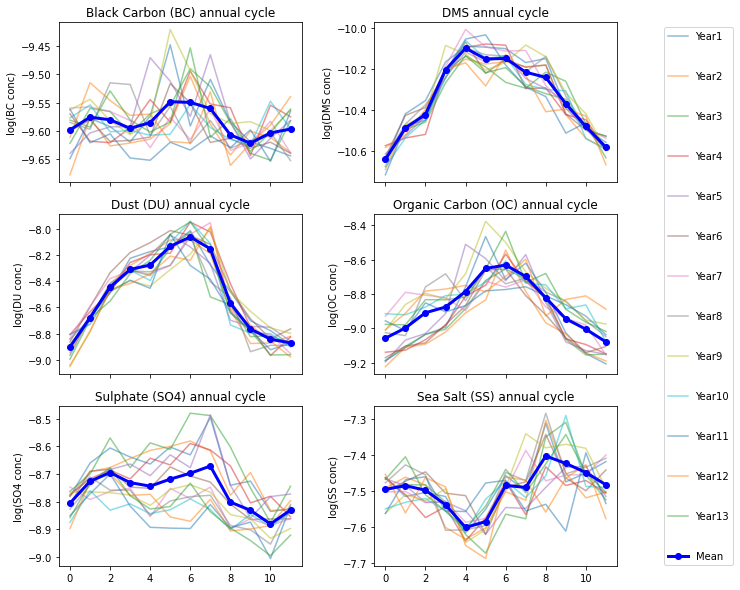

In [ ]:
figure, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex=True)
for i in range(0,13):
  ax[0,0].plot(np.log10(annual_aerosol_bcarbon[:,i]), label="Year"+str(i+1), alpha=0.5)
ax[0,0].plot(np.log10(np.mean(annual_aerosol_bcarbon, axis=(1))), 'bo-', lw = 3, label = 'Mean')
ax[0,0].set_title("Black Carbon (BC) annual cycle")
ax[0,0].set_ylabel("log(BC conc)")
for i in range(0,13):
  ax[0,1].plot(np.log10(annual_aerosol_dms[:,i]), label="Year"+str(i+1), alpha=0.5)
ax[0,1].plot(np.log10(np.mean(annual_aerosol_dms, axis=(1))), 'bo-', lw = 3, label = 'Mean')
ax[0,1].set_title("DMS annual cycle")
ax[0,1].set_ylabel("log(DMS conc)")
for i in range(0,13):
  ax[1,0].plot(np.log10(annual_aerosol_dust[:,i]), label="Year"+str(i+1), alpha=0.5)
ax[1,0].plot(np.log10(np.mean(annual_aerosol_dust, axis=(1))), 'bo-', lw = 3, label = 'Mean')
ax[1,0].set_title("Dust (DU) annual cycle")
ax[1,0].set_ylabel("log(DU conc)")
for i in range(0,13):
  ax[1,1].plot(np.log10(annual_aerosol_ocarbon[:,i]), label="Year"+str(i+1), alpha=0.5)
ax[1,1].plot(np.log10(np.mean(annual_aerosol_ocarbon, axis=(1))), 'bo-', lw = 3, label = 'Mean')
ax[1,1].set_title("Organic Carbon (OC) annual cycle")
ax[1,1].set_ylabel("log(OC conc)")
for i in range(0,13):
  ax[2,0].plot(np.log10(annual_aerosol_sulphate[:,i]), label="Year"+str(i+1), alpha=0.5)
ax[2,0].plot(np.log10(np.mean(annual_aerosol_sulphate, axis=(1))), 'bo-', lw = 3, label = 'Mean')
ax[2,0].set_title("Sulphate (SO4) annual cycle")
ax[2,0].set_ylabel("log(SO4 conc)")
for i in range(0,13):
  ax[2,1].plot(np.log10(annual_aerosol_seasalt[:,i]), label="Year"+str(i+1), alpha=0.5)
ax[2,1].plot(np.log10(np.mean(annual_aerosol_seasalt, axis=(1))), 'bo-', lw = 3, label = 'Mean')
ax[2,1].set_title("Sea Salt (SS) annual cycle")
ax[2,1].set_ylabel("log(SS conc)")
plt.subplots_adjust(wspace =0.3, hspace=0.2)
plt.legend(loc='best', labelspacing=3.0, bbox_to_anchor=(1.5, 3.4))
plt.show()

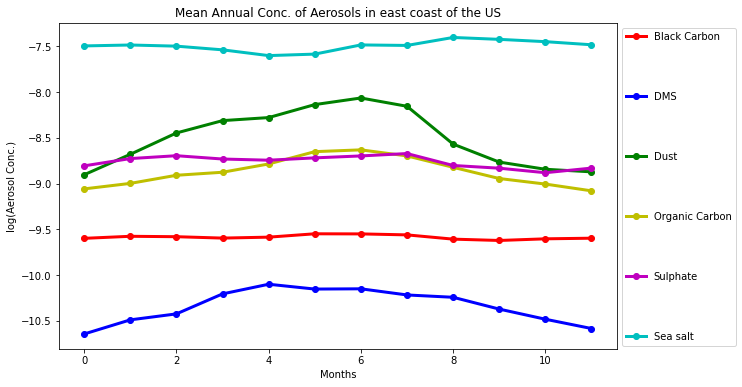

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.log10((np.mean(annual_aerosol_bcarbon, axis=(1)))), 'ro-', lw = 3, label = 'Black Carbon')
ax.plot(np.log10(np.mean(annual_aerosol_dms, axis=(1))), 'bo-', lw = 3, label = 'DMS')
ax.plot(np.log10(np.mean(annual_aerosol_dust, axis=(1))), 'go-', lw = 3, label = 'Dust')
ax.plot(np.log10(np.mean(annual_aerosol_ocarbon, axis=(1))), 'yo-', lw = 3, label = 'Organic Carbon')
ax.plot(np.log10(np.mean(annual_aerosol_sulphate, axis=(1))), 'mo-', lw = 3, label = 'Sulphate')
ax.plot(np.log10(np.mean(annual_aerosol_seasalt, axis=(1))), 'co-', lw = 3, label = 'Sea salt')
ax.legend(loc='best', labelspacing=5.0, bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("Months")
ax.set_ylabel("log(Aerosol Conc.)")
ax.set_title("Mean Annual Conc. of Aerosols in east coast of the US")
plt.show()

In [ ]:
import pandas as pd
bcarbon = np.log10(np.mean(annual_aerosol_bcarbon, axis=(1))).T
dms = np.log10(np.mean(annual_aerosol_dms, axis=(1))).T
dust = np.log10(np.mean(annual_aerosol_dust, axis=(1))).T
ocarbon = np.log10(np.mean(annual_aerosol_ocarbon, axis=(1))).T
sulphate = np.log10(np.mean(annual_aerosol_sulphate, axis=(1))).T
seasalt = np.log10(np.mean(annual_aerosol_seasalt, axis=(1))).T
cdnc = np.mean(annual_cdnc, axis=(1)).T

data = np.vstack([bcarbon, dms, dust, ocarbon, sulphate, seasalt, cdnc]).T
df = pd.DataFrame(data, columns = ['Bcarbon', 'DMS', 'Dust', 'Ocarbon', 'Sulphate', 'Seasalt', 'CDNC'])
df.head()

,Bcarbon,DMS,Dust,Ocarbon,Sulphate,Seasalt,CDNC
0,-9.597979,-10.643118,-8.903006,-9.057549,-8.805761,-7.495209,143.387100
1,-9.575608,-10.488773,-8.679592,-8.997486,-8.726254,-7.485079,133.635971
2,-9.580109,-10.423537,-8.446515,-8.908740,-8.694965,-7.497728,113.711899
3,-9.595276,-10.204978,-8.311551,-8.875787,-8.731140,-7.537960,107.305466
4,-9.584986,-10.099629,-8.278261,-8.785116,-8.744113,-7.600928,102.351768


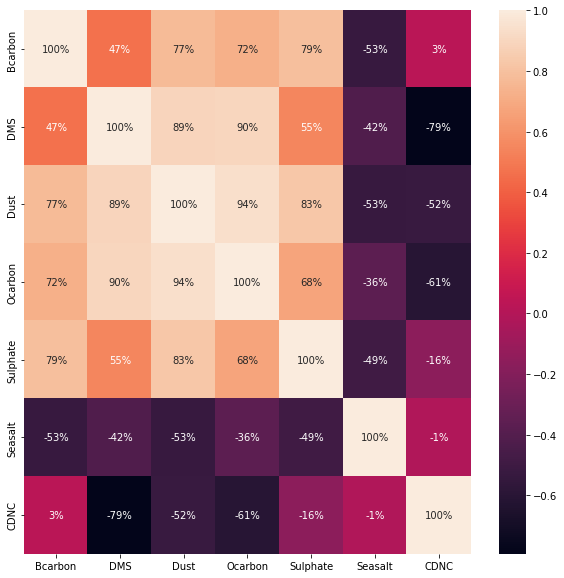

In [ ]:
import seaborn as sns
#Let's visualize the correlation of the features
plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[:, 0:7].corr(), annot=True, fmt='.0%')

In [ ]:
from scipy.stats import spearmanr
cols = df.columns
for col in cols[:-1]:
    rho, p = spearmanr(df[col].values, df['CDNC'].values)
    print('Spearman correlation between CDNC and %s is %s' %(col, round(rho, 4)))

Spearman correlation between CDNC and Bcarbon is 0.1399
Spearman correlation between CDNC and DMS is -0.7063
Spearman correlation between CDNC and Dust is -0.4755
Spearman correlation between CDNC and Ocarbon is -0.5804
Spearman correlation between CDNC and Sulphate is -0.0839
Spearman correlation between CDNC and Seasalt is 0.0629


### Task 2 [30 points]
*   derive the time series of the domain averaged and annual mean of CDNC in the east coast of the U.S.
*   derive the time series of the domain averaged and annual mean of each aerosol type in the east coast of the U.S.
*   use linear regression to analyze the trend of CDNC and each aerosol over the 13 years period of 2003-2015
*   repeat the above analysis but for each seaons (Spring:MAM, Summer:JJA, Fall:SON, Winter:DJF)

In [ ]:
from scipy.stats import linregress

In [ ]:
m1,b1,r1,p1,sigma1 = linregress(np.arange(0,cdnc_mean.size), cdnc_mean)
time_series_annual_cdnc_mean = np.mean(annual_cdnc, axis=0)
m2,b2,r2,p2,sigma2 = linregress(np.arange(0,time_series_annual_cdnc_mean.size), time_series_annual_cdnc_mean)
print(linregress(np.arange(0,cdnc_mean.size), cdnc_mean))
print(linregress(np.arange(0,time_series_annual_cdnc_mean.size), time_series_annual_cdnc_mean))

LinregressResult(slope=-0.2970695176061041, intercept=138.19292393039103, rvalue=-0.6028111021967805, pvalue=8.341830348292814e-17, stderr=0.03168518225930145, intercept_stderr=2.8400541984113117)
LinregressResult(slope=-3.4969002859933047, intercept=136.1514380318778, rvalue=-0.9936470234455629, pvalue=8.672961503393991e-12, stderr=0.11941737783429335, intercept_stderr=0.8444083765814494)


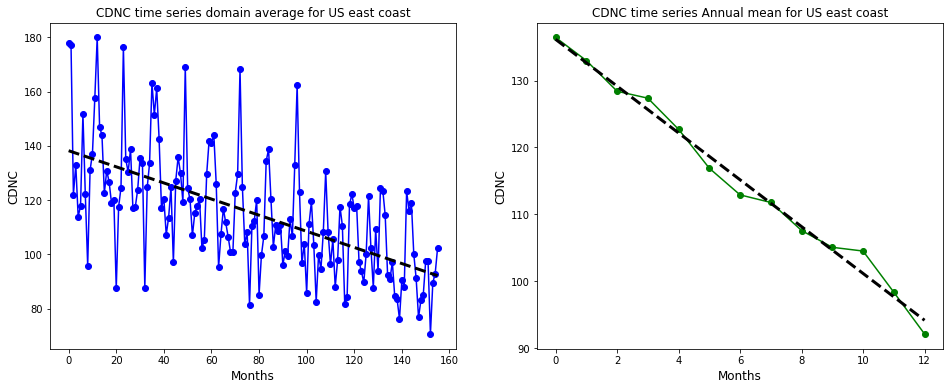

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(cdnc_mean, 'bo-')
ax1.plot(m1*np.arange(0,cdnc_mean.size)+b1, 'k--', lw = 3)
ax1.set_title("CDNC time series domain average for US east coast",fontsize='large')
ax1.set_xlabel("Months",fontsize='large')
ax1.set_ylabel("CDNC",fontsize='large')

ax2.plot(time_series_annual_cdnc_mean, 'go-')
ax2.plot(m2*np.arange(0,time_series_annual_cdnc_mean.size)+b2, 'k--', lw = 3)
ax2.set_title(r"CDNC time series Annual mean for US east coast",fontsize='large')
ax2.set_xlabel("Months",fontsize='large')
ax2.set_ylabel("CDNC",fontsize='large')
plt.show()

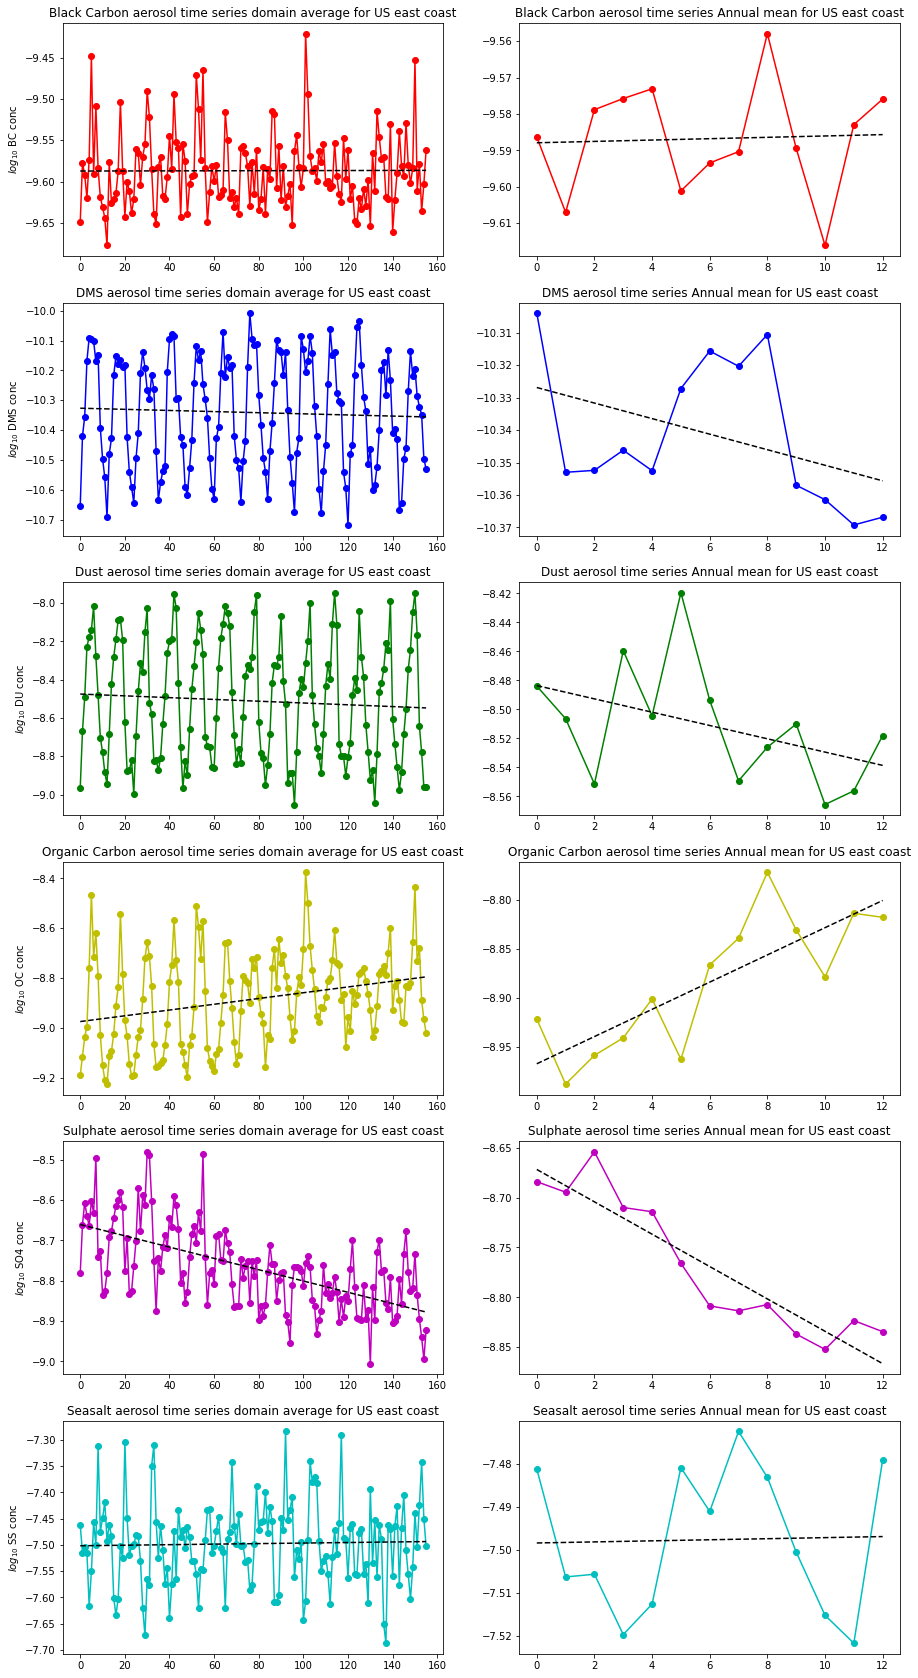

In [ ]:
fig, ax = plt.subplots(6,2, figsize = (15,30))

#bc
ax[0,0].plot(np.log10(aerosol_bcarbon_mean), 'ro-')
m,b,r,p,sigma = linregress(np.arange(0,aerosol_bcarbon_mean.size), np.log10(aerosol_bcarbon_mean))
ax[0,0].plot(m*np.arange(0,aerosol_bcarbon_mean.size)+b, 'k--')
ax[0,0].set_title("Black Carbon aerosol time series domain average for US east coast")
time_series_annual_bcarbon_mean = np.mean(np.log10(aerosol_bcarbon_mean.reshape(13,12)), axis=(1))
ax[0,1].plot(time_series_annual_bcarbon_mean, 'ro-')
m,b,r,p,sigma = linregress(np.arange(0,time_series_annual_bcarbon_mean.size), time_series_annual_bcarbon_mean)
ax[0,1].plot(m*np.arange(0,time_series_annual_bcarbon_mean.size)+b, 'k--')
ax[0,1].set_title("Black Carbon aerosol time series Annual mean for US east coast")
#dms
ax[1,0].plot(np.log10(aerosol_dms_mean), 'bo-')
m,b,r,p,sigma = linregress(np.arange(0,aerosol_dms_mean.size), np.log10(aerosol_dms_mean))
ax[1,0].plot(m*np.arange(0,aerosol_dms_mean.size)+b, 'k--')
ax[1,0].set_title("DMS aerosol time series domain average for US east coast")
time_series_annual_dms_mean = np.mean(np.log10(aerosol_dms_mean.reshape(13,12)), axis=(1))
ax[1,1].plot(time_series_annual_dms_mean, 'bo-')
m,b,r,p,sigma = linregress(np.arange(0,time_series_annual_dms_mean.size), time_series_annual_dms_mean)
ax[1,1].plot(m*np.arange(0,time_series_annual_dms_mean.size)+b, 'k--')
ax[1,1].set_title("DMS aerosol time series Annual mean for US east coast")
#dust
ax[2,0].plot(np.log10(aerosol_dust_mean), 'go-')
m,b,r,p,sigma = linregress(np.arange(0,aerosol_dust_mean.size), np.log10(aerosol_dust_mean))
ax[2,0].plot(m*np.arange(0,aerosol_dust_mean.size)+b, 'k--')
ax[2,0].set_title("Dust aerosol time series domain average for US east coast")
time_series_annual_dust_mean = np.mean(np.log10(aerosol_dust_mean.reshape(13,12)), axis=(1))
ax[2,1].plot(time_series_annual_dust_mean, 'go-')
m,b,r,p,sigma = linregress(np.arange(0,time_series_annual_dust_mean.size), time_series_annual_dust_mean)
ax[2,1].plot(m*np.arange(0,time_series_annual_dust_mean.size)+b, 'k--')
ax[2,1].set_title("Dust aerosol time series Annual mean for US east coast")
#Ocarbon
ax[3,0].plot(np.log10(aerosol_ocarbon_mean), 'yo-')
m,b,r,p,sigma = linregress(np.arange(0,aerosol_ocarbon_mean.size), np.log10(aerosol_ocarbon_mean))
ax[3,0].plot(m*np.arange(0,aerosol_ocarbon_mean.size)+b, 'k--')
ax[3,0].set_title("Organic Carbon aerosol time series domain average for US east coast")
time_series_annual_ocarbon_mean = np.mean(np.log10(aerosol_ocarbon_mean.reshape(13,12)), axis=(1))
ax[3,1].plot(time_series_annual_ocarbon_mean, 'yo-')
m,b,r,p,sigma = linregress(np.arange(0,time_series_annual_ocarbon_mean.size), time_series_annual_ocarbon_mean)
ax[3,1].plot(m*np.arange(0,time_series_annual_ocarbon_mean.size)+b, 'k--')
ax[3,1].set_title("Organic Carbon aerosol time series Annual mean for US east coast")
#sulphate
ax[4,0].plot(np.log10(aerosol_sulphate_mean), 'mo-')
m,b,r,p,sigma = linregress(np.arange(0,aerosol_sulphate_mean.size), np.log10(aerosol_sulphate_mean))
ax[4,0].plot(m*np.arange(0,aerosol_sulphate_mean.size)+b, 'k--')
ax[4,0].set_title("Sulphate aerosol time series domain average for US east coast")
time_series_annual_sulphate_mean = np.mean(np.log10(aerosol_sulphate_mean.reshape(13,12)), axis=(1))
ax[4,1].plot(time_series_annual_sulphate_mean, 'mo-')
m,b,r,p,sigma = linregress(np.arange(0,time_series_annual_sulphate_mean.size), time_series_annual_sulphate_mean)
ax[4,1].plot(m*np.arange(0,time_series_annual_sulphate_mean.size)+b, 'k--')
ax[4,1].set_title("Sulphate aerosol time series Annual mean for US east coast")
#seasalt
ax[5,0].plot(np.log10(aerosol_seasalt_mean), 'co-')
m,b,r,p,sigma = linregress(np.arange(0,aerosol_seasalt_mean.size), np.log10(aerosol_seasalt_mean))
ax[5,0].plot(m*np.arange(0,aerosol_seasalt_mean.size)+b, 'k--')
ax[5,0].set_title("Seasalt aerosol time series domain average for US east coast")
time_series_annual_seasalt_mean = np.mean(np.log10(aerosol_seasalt_mean.reshape(13,12)), axis=(1))
ax[5,1].plot(time_series_annual_seasalt_mean, 'co-')
m,b,r,p,sigma = linregress(np.arange(0,time_series_annual_seasalt_mean.size), time_series_annual_seasalt_mean)
ax[5,1].plot(m*np.arange(0,time_series_annual_seasalt_mean.size)+b, 'k--')
ax[5,1].set_title("Seasalt aerosol time series Annual mean for US east coast")
ax[0,0].set_ylabel(r"$log_{10}$ BC conc")
ax[1,0].set_ylabel(r"$log_{10}$ DMS conc")
ax[2,0].set_ylabel(r"$log_{10}$ DU conc")
ax[3,0].set_ylabel(r"$log_{10}$ OC conc")
ax[4,0].set_ylabel(r"$log_{10}$ SO4 conc")
ax[5,0].set_ylabel(r"$log_{10}$ SS conc")
plt.show()

spring -> LinregressResult(slope=-3.7909747532435825, intercept=130.53555951799666, rvalue=-0.9443247035159125, pvalue=1.2068669506299873e-06, stderr=0.39824365476068374, intercept_stderr=2.816007888457938)
summer -> LinregressResult(slope=-3.0731548267406414, intercept=129.8145240532173, rvalue=-0.8747594943618789, pvalue=9.088938554420019e-05, stderr=0.5132685100053106, intercept_stderr=3.6293564399427045)
fall -> LinregressResult(slope=-2.523077199747275, intercept=119.71802252465552, rvalue=-0.8718445505270926, pvalue=0.00010255032945378417, stderr=0.4273646222410038, intercept_stderr=3.0219242242584103)
winter -> LinregressResult(slope=-4.6003958733527215, intercept=164.53766271570225, rvalue=-0.9561048047076948, pvalue=3.3399497207987883e-07, stderr=0.4251066655817618, intercept_stderr=3.005958059604657)


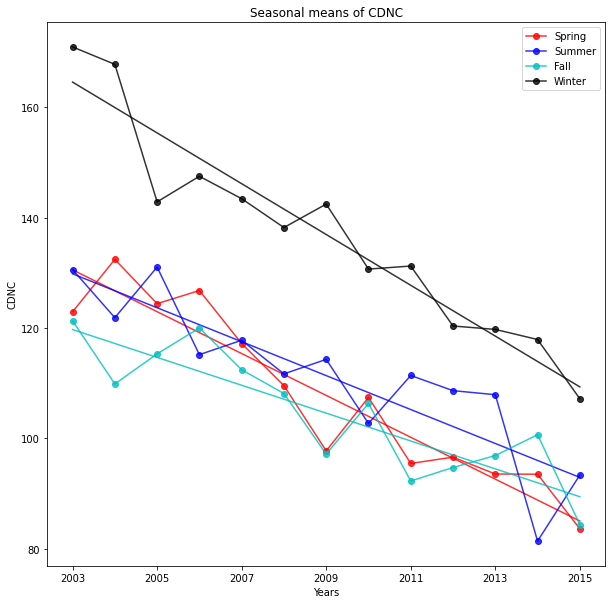

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#Spring
time_series_spring_cdnc_mean = np.mean(annual_cdnc[[2,3,4],:], axis=0)
ax.plot(time_series_spring_cdnc_mean, alpha=0.8, marker = 'o', color="r", label='Spring')
m,b,r,p,sigma = linregress(np.arange(0,time_series_spring_cdnc_mean.size), time_series_spring_cdnc_mean)
ax.plot(m*np.arange(0,time_series_spring_cdnc_mean.size)+b, alpha=0.8, color="r")
print("spring ->", linregress(np.arange(0,time_series_spring_cdnc_mean.size),time_series_spring_cdnc_mean))
#Summer
time_series_summer_cdnc_mean = np.mean(annual_cdnc[[5,6,7],:], axis=0)
ax.plot(time_series_summer_cdnc_mean, alpha=0.8, marker ='o', label="Summer", color="b")
m,b,r,p,sigma = linregress(np.arange(0,time_series_summer_cdnc_mean.size), time_series_summer_cdnc_mean)
ax.plot(m*np.arange(0,time_series_summer_cdnc_mean.size)+b, alpha=0.8, color="b")
print("summer ->", linregress(np.arange(0,time_series_summer_cdnc_mean.size),time_series_summer_cdnc_mean))
#Fall
time_series_fall_cdnc_mean = np.mean(annual_cdnc[[8,9,10],:], axis=0)
ax.plot(time_series_fall_cdnc_mean, alpha=0.8, marker ='o', label="Fall", color='c')
m,b,r,p,sigma = linregress(np.arange(0,time_series_fall_cdnc_mean.size), time_series_fall_cdnc_mean)
ax.plot(m*np.arange(0,time_series_fall_cdnc_mean.size)+b, alpha=0.8, color="c")
print("fall ->", linregress(np.arange(0,time_series_fall_cdnc_mean.size), time_series_fall_cdnc_mean))
#Winter
time_series_winter_cdnc_mean = np.mean(annual_cdnc[[-1,0,1],:], axis=0)
ax.plot(time_series_winter_cdnc_mean, alpha=0.8, marker ='o', label="Winter", color="k")
m,b,r,p,sigma = linregress(np.arange(0,time_series_winter_cdnc_mean.size), time_series_winter_cdnc_mean)
ax.plot(m*np.arange(0,time_series_winter_cdnc_mean.size)+b, alpha=0.8, color="k")
print("winter ->", linregress(np.arange(0,time_series_winter_cdnc_mean.size), time_series_winter_cdnc_mean))

ax.set_title("Seasonal means of CDNC")
ax.set_xlabel("Years")
ax.set_ylabel("CDNC")
ax.set_xticklabels(['2002', '2003', '2005', '2007', '2009', '2011', '2013', '2015'])
plt.legend()
plt.show()

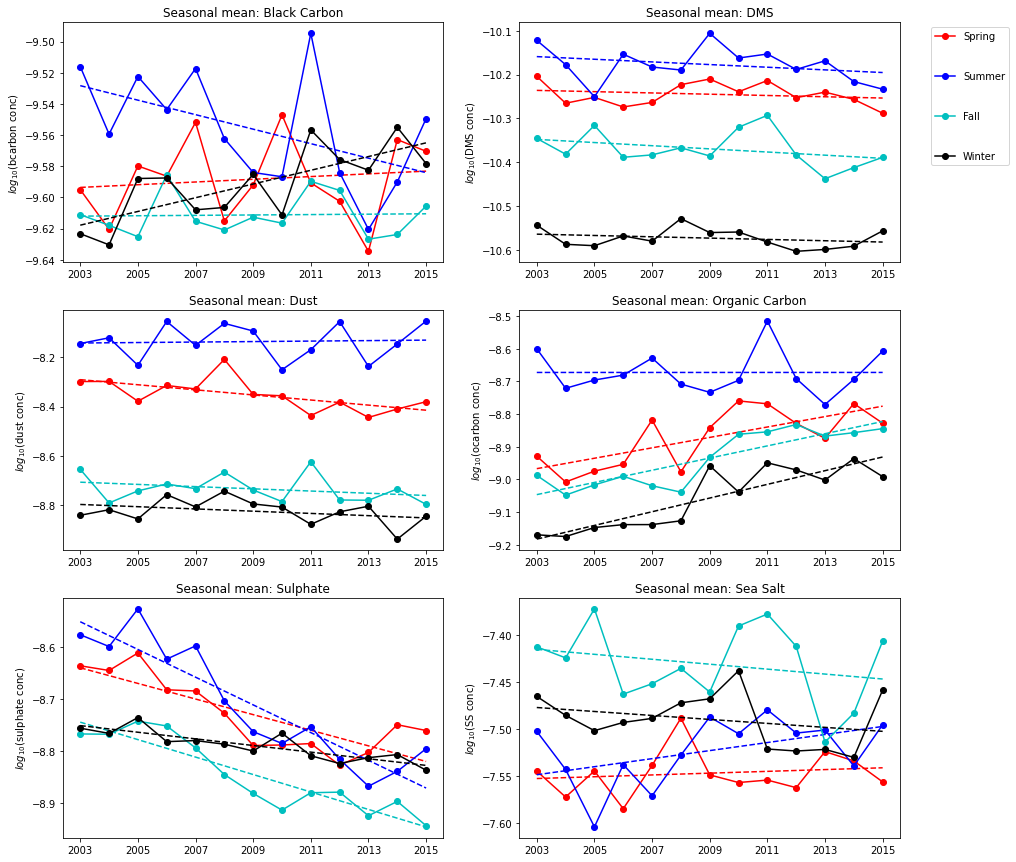

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (15,15))

#black carbon
time_series_spring_bcarbon_mean = np.mean(np.log10(aerosol_bcarbon_mean.reshape(13,12)[:,[2,3,4]]), axis=(1))
ax[0,0].plot(time_series_spring_bcarbon_mean, 'o-', color="r")
m,b,r,p,sigma = linregress(np.arange(0,time_series_spring_bcarbon_mean.size), time_series_spring_bcarbon_mean)
ax[0,0].plot(m*np.arange(0,time_series_spring_bcarbon_mean.size)+b, '--', color="r")
time_series_summer_bcarbon_mean = np.mean(np.log10(aerosol_bcarbon_mean.reshape(13,12)[:,[5,6,7]]), axis=(1))
ax[0,0].plot(time_series_summer_bcarbon_mean, 'o-', color="b")
m,b,r,p,sigma = linregress(np.arange(0,time_series_summer_bcarbon_mean.size), time_series_summer_bcarbon_mean)
ax[0,0].plot(m*np.arange(0,time_series_summer_bcarbon_mean.size)+b, '--', color="b")
time_series_fall_bcarbon_mean = np.mean(np.log10(aerosol_bcarbon_mean.reshape(13,12)[:,[8,9,10]]), axis=(1))
ax[0,0].plot(time_series_fall_bcarbon_mean, 'o-', color="c")
m,b,r,p,sigma = linregress(np.arange(0,time_series_fall_bcarbon_mean.size), time_series_fall_bcarbon_mean)
ax[0,0].plot(m*np.arange(0,time_series_fall_bcarbon_mean.size)+b, '--', color="c")
time_series_winter_bcarbon_mean = np.mean(np.log10(aerosol_bcarbon_mean.reshape(13,12)[:,[-1,0,1]]), axis=(1))
ax[0,0].plot(time_series_winter_bcarbon_mean, 'o-', color="k")
m,b,r,p,sigma = linregress(np.arange(0,time_series_winter_bcarbon_mean.size), time_series_winter_bcarbon_mean)
ax[0,0].plot(m*np.arange(0,time_series_winter_bcarbon_mean.size)+b, '--', color="k")
ax[0,0].set_title("Seasonal mean: Black Carbon")
ax[0,0].set_ylabel(r"$log_{10}$(bcarbon conc)")
ax[0,0].set_xticklabels(['2002', '2003', '2005', '2007', '2009', '2011', '2013', '2015'])

#Dms
time_series_spring_dms_mean = np.mean(np.log10(aerosol_dms_mean.reshape(13,12)[:,[2,3,4]]), axis=(1))
ax[0,1].plot(time_series_spring_dms_mean, 'o-', color="r", label = "Spring")
m,b,r,p,sigma = linregress(np.arange(0,time_series_spring_dms_mean.size), time_series_spring_dms_mean)
ax[0,1].plot(m*np.arange(0,time_series_spring_dms_mean.size)+b, '--', color="r")
time_series_summer_dms_mean = np.mean(np.log10(aerosol_dms_mean.reshape(13,12)[:,[5,6,7]]), axis=(1))
ax[0,1].plot(time_series_summer_dms_mean, 'o-', color="b", label = "Summer")
m,b,r,p,sigma = linregress(np.arange(0,time_series_summer_dms_mean.size), time_series_summer_dms_mean)
ax[0,1].plot(m*np.arange(0,time_series_summer_dms_mean.size)+b, '--', color="b")
time_series_fall_dms_mean = np.mean(np.log10(aerosol_dms_mean.reshape(13,12)[:,[8,9,10]]), axis=(1))
ax[0,1].plot(time_series_fall_dms_mean, 'o-', color="c", label = "Fall")
m,b,r,p,sigma = linregress(np.arange(0,time_series_fall_dms_mean.size), time_series_fall_dms_mean)
ax[0,1].plot(m*np.arange(0,time_series_fall_dms_mean.size)+b, '--', color="c")
time_series_winter_dms_mean = np.mean(np.log10(aerosol_dms_mean.reshape(13,12)[:,[-1,0,1]]), axis=(1))
ax[0,1].plot(time_series_winter_dms_mean, 'o-', color="k", label = "Winter")
m,b,r,p,sigma = linregress(np.arange(0,time_series_winter_dms_mean.size), time_series_winter_dms_mean)
ax[0,1].plot(m*np.arange(0,time_series_winter_dms_mean.size)+b, '--', color="k")
ax[0,1].set_title("Seasonal mean: DMS")
ax[0,1].legend(loc='upper right', labelspacing=3.0, bbox_to_anchor=(1.3, 1.0))
ax[0,1].set_ylabel(r"$log_{10}$(DMS conc)")
ax[0,1].set_xticklabels(['2002', '2003', '2005', '2007', '2009', '2011', '2013', '2015'])

#Dust
time_series_spring_dust_mean = np.mean(np.log10(aerosol_dust_mean.reshape(13,12)[:,[2,3,4]]), axis=(1))
ax[1,0].plot(time_series_spring_dust_mean, 'o-', color="r")
m,b,r,p,sigma = linregress(np.arange(0,time_series_spring_dust_mean.size), time_series_spring_dust_mean)
ax[1,0].plot(m*np.arange(0,time_series_spring_dust_mean.size)+b, '--', color="r")
time_series_summer_dust_mean = np.mean(np.log10(aerosol_dust_mean.reshape(13,12)[:,[5,6,7]]), axis=(1))
ax[1,0].plot(time_series_summer_dust_mean, 'o-', color="b")
m,b,r,p,sigma = linregress(np.arange(0,time_series_summer_dust_mean.size), time_series_summer_dust_mean)
ax[1,0].plot(m*np.arange(0,time_series_summer_dust_mean.size)+b, '--', color="b")
time_series_fall_dust_mean = np.mean(np.log10(aerosol_dust_mean.reshape(13,12)[:,[8,9,10]]), axis=(1))
ax[1,0].plot(time_series_fall_dust_mean, 'o-', color="c")
m,b,r,p,sigma = linregress(np.arange(0,time_series_fall_dust_mean.size), time_series_fall_dust_mean)
ax[1,0].plot(m*np.arange(0,time_series_fall_dust_mean.size)+b, '--', color="c")
time_series_winter_dust_mean = np.mean(np.log10(aerosol_dust_mean.reshape(13,12)[:,[-1,0,1]]), axis=(1))
ax[1,0].plot(time_series_winter_dust_mean, 'o-', color="k")
m,b,r,p,sigma = linregress(np.arange(0,time_series_winter_dust_mean.size), time_series_winter_dust_mean)
ax[1,0].plot(m*np.arange(0,time_series_winter_dust_mean.size)+b, '--', color="k")
ax[1,0].set_title("Seasonal mean: Dust")
ax[1,0].set_ylabel(r"$log_{10}$(dust conc)")
ax[1,0].set_xticklabels(['2002', '2003', '2005', '2007', '2009', '2011', '2013', '2015'])

#Organic carbon
time_series_spring_ocarbon_mean = np.mean(np.log10(aerosol_ocarbon_mean.reshape(13,12)[:,[2,3,4]]), axis=(1))
ax[1,1].plot(time_series_spring_ocarbon_mean, 'o-', color="r")
m,b,r,p,sigma = linregress(np.arange(0,time_series_spring_ocarbon_mean.size), time_series_spring_ocarbon_mean)
ax[1,1].plot(m*np.arange(0,time_series_spring_ocarbon_mean.size)+b, '--', color="r")
time_series_summer_ocarbon_mean = np.mean(np.log10(aerosol_ocarbon_mean.reshape(13,12)[:,[5,6,7]]), axis=(1))
ax[1,1].plot(time_series_summer_ocarbon_mean, 'o-', color="b")
m,b,r,p,sigma = linregress(np.arange(0,time_series_summer_ocarbon_mean.size), time_series_summer_ocarbon_mean)
ax[1,1].plot(m*np.arange(0,time_series_summer_ocarbon_mean.size)+b, '--', color="b")
time_series_fall_ocarbon_mean = np.mean(np.log10(aerosol_ocarbon_mean.reshape(13,12)[:,[8,9,10]]), axis=(1))
ax[1,1].plot(time_series_fall_ocarbon_mean, 'o-', color="c")
m,b,r,p,sigma = linregress(np.arange(0,time_series_fall_ocarbon_mean.size), time_series_fall_ocarbon_mean)
ax[1,1].plot(m*np.arange(0,time_series_fall_ocarbon_mean.size)+b, '--', color="c")
time_series_winter_ocarbon_mean = np.mean(np.log10(aerosol_ocarbon_mean.reshape(13,12)[:,[-1,0,1]]), axis=(1))
ax[1,1].plot(time_series_winter_ocarbon_mean, 'o-',  color="k")
m,b,r,p,sigma = linregress(np.arange(0,time_series_winter_ocarbon_mean.size), time_series_winter_ocarbon_mean)
ax[1,1].plot(m*np.arange(0,time_series_winter_ocarbon_mean.size)+b, '--', color="k")
ax[1,1].set_title("Seasonal mean: Organic Carbon")
#ax[1,1].legend(loc='center left', labelspacing=13.0, bbox_to_anchor=(1.0, 0.5))
ax[1,1].set_ylabel(r"$log_{10}$(ocarbon conc)")
ax[1,1].set_xticklabels(['2002', '2003', '2005', '2007', '2009', '2011', '2013', '2015'])

#Sulphate
time_series_spring_sulphate_mean = np.mean(np.log10(aerosol_sulphate_mean.reshape(13,12)[:,[2,3,4]]), axis=(1))
ax[2,0].plot(time_series_spring_sulphate_mean, 'o-', color="r")
m,b,r,p,sigma = linregress(np.arange(0,time_series_spring_sulphate_mean.size), time_series_spring_sulphate_mean)
ax[2,0].plot(m*np.arange(0,time_series_spring_sulphate_mean.size)+b, '--', color="r")
time_series_summer_sulphate_mean = np.mean(np.log10(aerosol_sulphate_mean.reshape(13,12)[:,[5,6,7]]), axis=(1))
ax[2,0].plot(time_series_summer_sulphate_mean, 'o-', color="b")
m,b,r,p,sigma = linregress(np.arange(0,time_series_summer_sulphate_mean.size), time_series_summer_sulphate_mean)
ax[2,0].plot(m*np.arange(0,time_series_summer_sulphate_mean.size)+b, '--', color="b")
time_series_fall_sulphate_mean = np.mean(np.log10(aerosol_sulphate_mean.reshape(13,12)[:,[8,9,10]]), axis=(1))
ax[2,0].plot(time_series_fall_sulphate_mean, 'o-', color="c")
m,b,r,p,sigma = linregress(np.arange(0,time_series_fall_sulphate_mean.size), time_series_fall_sulphate_mean)
ax[2,0].plot(m*np.arange(0,time_series_fall_sulphate_mean.size)+b, '--', color="c")
time_series_winter_sulphate_mean = np.mean(np.log10(aerosol_sulphate_mean.reshape(13,12)[:,[-1,0,1]]), axis=(1))
ax[2,0].plot(time_series_winter_sulphate_mean, 'o-', color="k")
m,b,r,p,sigma = linregress(np.arange(0,time_series_winter_sulphate_mean.size), time_series_winter_sulphate_mean)
ax[2,0].plot(m*np.arange(0,time_series_winter_sulphate_mean.size)+b, '--', color="k")
ax[2,0].set_title("Seasonal mean: Sulphate")
ax[2,0].set_ylabel(r"$log_{10}$(sulphate conc)")
ax[2,0].set_xticklabels(['2002', '2003', '2005', '2007', '2009', '2011', '2013', '2015'])

#Sea salt
time_series_spring_seasalt_mean = np.mean(np.log10(aerosol_seasalt_mean.reshape(13,12)[:,[2,3,4]]), axis=(1))
ax[2,1].plot(time_series_spring_seasalt_mean, 'o-', color="r")
m,b,r,p,sigma = linregress(np.arange(0,time_series_spring_seasalt_mean.size), time_series_spring_seasalt_mean)
ax[2,1].plot(m*np.arange(0,time_series_spring_seasalt_mean.size)+b, '--', color="r")
time_series_summer_seasalt_mean = np.mean(np.log10(aerosol_seasalt_mean.reshape(13,12)[:,[5,6,7]]), axis=(1))
ax[2,1].plot(time_series_summer_seasalt_mean, 'o-', color="b")
m,b,r,p,sigma = linregress(np.arange(0,time_series_summer_seasalt_mean.size), time_series_summer_seasalt_mean)
ax[2,1].plot(m*np.arange(0,time_series_summer_seasalt_mean.size)+b, '--', color="b")
time_series_fall_seasalt_mean = np.mean(np.log10(aerosol_seasalt_mean.reshape(13,12)[:,[8,9,10]]), axis=(1))
ax[2,1].plot(time_series_fall_seasalt_mean, 'o-', color="c")
m,b,r,p,sigma = linregress(np.arange(0,time_series_fall_seasalt_mean.size), time_series_fall_seasalt_mean)
ax[2,1].plot(m*np.arange(0,time_series_fall_seasalt_mean.size)+b, '--', color="c")
time_series_winter_seasalt_mean = np.mean(np.log10(aerosol_seasalt_mean.reshape(13,12)[:,[-1,0,1]]), axis=(1))
ax[2,1].plot(time_series_winter_seasalt_mean, 'o-', color="k")
m,b,r,p,sigma = linregress(np.arange(0,time_series_winter_seasalt_mean.size), time_series_winter_seasalt_mean)
ax[2,1].plot(m*np.arange(0,time_series_winter_seasalt_mean.size)+b, '--', color="k")
ax[2,1].set_title("Seasonal mean: Sea Salt")
ax[2,1].set_ylabel(r"$log_{10}$(SS conc)")
ax[2,1].set_xticklabels(['2002', '2003', '2005', '2007', '2009', '2011', '2013', '2015'])
plt.show()

### Task 3 [20 points]



*   Perform linear regression between the mass concentration between the time series (13 years of domain averaged and annual value) of CDNC and that of each aerosol type.
*   What is the r-value, p-value and correlation coefficient of each regression?
*   Do you think kowing the inter-annual variation of aerosol helps explain the trend of CDNC?




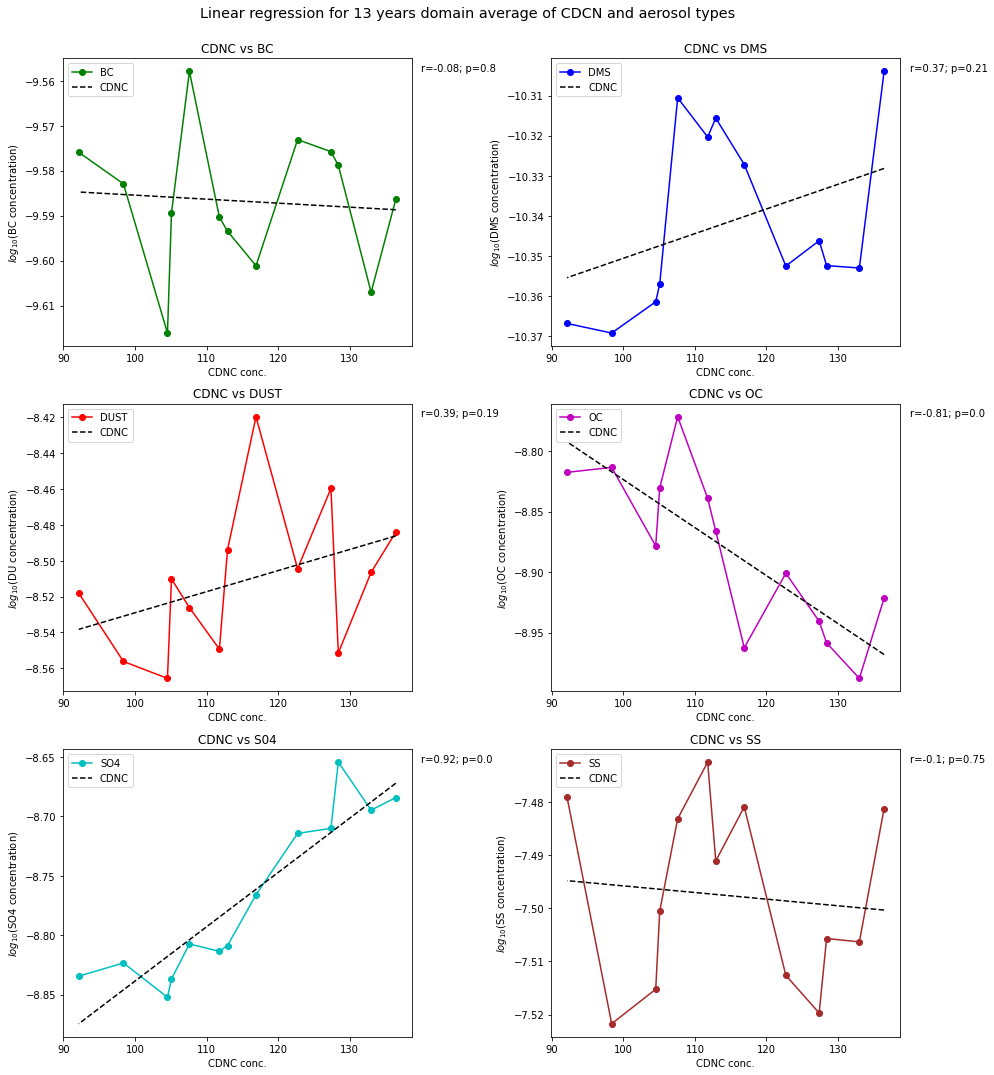

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(15,18))
ax[0,0].plot(time_series_annual_cdnc_mean, time_series_annual_bcarbon_mean, '-o', color='g', label='BC')
#Black Carbon
m,b,r,p,sigma = linregress(time_series_annual_cdnc_mean, time_series_annual_bcarbon_mean)
ax[0,0].plot(time_series_annual_cdnc_mean, m*time_series_annual_cdnc_mean+b, 'k--', label='CDNC')
ax[0,0].text(140, np.amax(time_series_annual_bcarbon_mean), f"r={round(r,2)}; p={round(p,2)}")
ax[0,0].set_title("CDNC vs BC")
ax[0,0].set_ylabel(r"$log_{10}$(BC concentration)")
fig.suptitle('Linear regression for 13 years domain average of CDCN and aerosol types', fontsize='x-large', y=0.92)
#DMS
ax[0,1].plot(time_series_annual_cdnc_mean, time_series_annual_dms_mean, 'o-', color='b', label='DMS')
m,b,r,p,sigma = linregress(time_series_annual_cdnc_mean, time_series_annual_dms_mean)
ax[0,1].plot(time_series_annual_cdnc_mean, m*time_series_annual_cdnc_mean+b, 'k--', label='CDNC')
ax[0,1].text(140, np.amax(time_series_annual_dms_mean), f"r={round(r,2)}; p={round(p,2)}")
ax[0,1].set_title("CDNC vs DMS")
ax[0,1].set_ylabel(r"$log_{10}$(DMS concentration)")
#Dust
ax[1,0].plot(time_series_annual_cdnc_mean, time_series_annual_dust_mean, 'o-', color='r', label='DUST')
m,b,r,p,sigma = linregress(time_series_annual_cdnc_mean, time_series_annual_dust_mean)
ax[1,0].plot(time_series_annual_cdnc_mean, m*time_series_annual_cdnc_mean+b, 'k--', label='CDNC')
ax[1,0].text(140, np.amax(time_series_annual_dust_mean), f"r={round(r,2)}; p={round(p,2)}")
ax[1,0].set_title("CDNC vs DUST")
ax[1,0].set_ylabel(r"$log_{10}$(DU concentration)")
#Organic carbon
ax[1,1].plot(time_series_annual_cdnc_mean, time_series_annual_ocarbon_mean, 'o-', color='m', label='OC')
m,b,r,p,sigma = linregress(time_series_annual_cdnc_mean, time_series_annual_ocarbon_mean)
ax[1,1].plot(time_series_annual_cdnc_mean, m*time_series_annual_cdnc_mean+b, 'k--', label='CDNC')
ax[1,1].text(140, np.amax(time_series_annual_ocarbon_mean), f"r={round(r,2)}; p={round(p,2)}")
ax[1,1].set_title("CDNC vs OC")
ax[1,1].set_ylabel(r"$log_{10}$(OC concentration)")
#Sulphate
ax[2,0].plot(time_series_annual_cdnc_mean, time_series_annual_sulphate_mean, 'o-', color='c', label='SO4')
m,b,r,p,sigma = linregress(time_series_annual_cdnc_mean, time_series_annual_sulphate_mean)
ax[2,0].plot(time_series_annual_cdnc_mean, m*time_series_annual_cdnc_mean+b, 'k--', label='CDNC')
ax[2,0].text(140, np.amax(time_series_annual_sulphate_mean), f"r={round(r,2)}; p={round(p,2)}")
ax[2,0].set_title("CDNC vs S04")
ax[2,0].set_ylabel(r"$log_{10}$(SO4 concentration)")
#Sea salt
ax[2,1].plot(time_series_annual_cdnc_mean, time_series_annual_seasalt_mean, 'o-', color='brown', label='SS')
m,b,r,p,sigma = linregress(time_series_annual_cdnc_mean, time_series_annual_seasalt_mean)
ax[2,1].plot(time_series_annual_cdnc_mean, m*time_series_annual_cdnc_mean+b, 'k--', label='CDNC')
ax[2,1].text(140, np.amax(time_series_annual_seasalt_mean), f"r={round(r,2)}; p={round(p,2)}")
ax[2,1].set_title("CDNC vs SS")
ax[2,1].set_ylabel(r"$log_{10}$(SS concentration)")
ax[0,0].set_xlabel("CDNC conc.")
ax[0,1].set_xlabel("CDNC conc.")
ax[1,0].set_xlabel("CDNC conc.")
ax[1,1].set_xlabel("CDNC conc.")
ax[2,0].set_xlabel("CDNC conc.")
ax[2,1].set_xlabel("CDNC conc.")
ax[0,0].legend(loc='upper left')
ax[0,1].legend(loc='upper left')
ax[1,0].legend(loc='upper left')
ax[1,1].legend(loc='upper left')
ax[2,0].legend(loc='upper left')
ax[2,1].legend(loc='upper left')
plt.subplots_adjust(wspace=0.4)
plt.show()

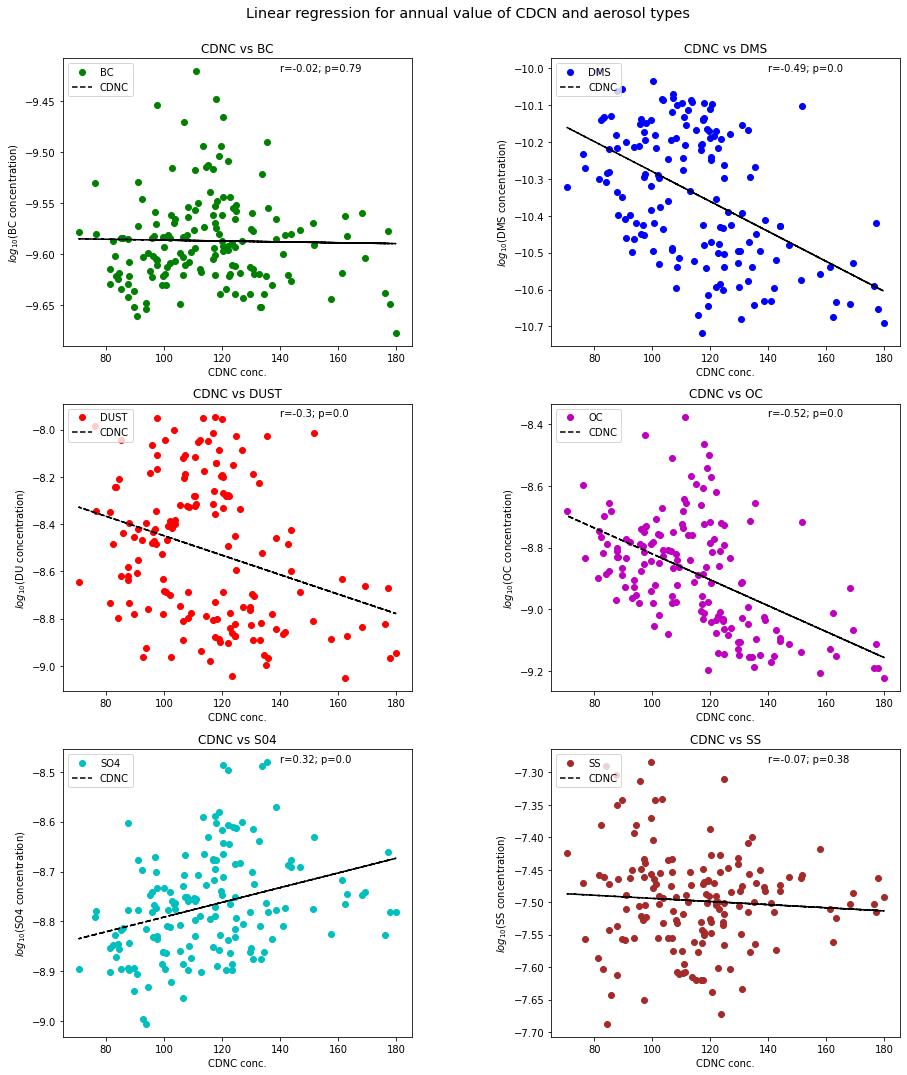

In [ ]:
# Multi-linear regression for 13 years domain average of CDCN and aerosol types
bcarbon0 = np.log10(aerosol_bcarbon_mean)
dms0 = np.log10(aerosol_dms_mean)
dust0 = np.log10(aerosol_dust_mean)
ocarbon0 = np.log10(aerosol_ocarbon_mean)
sulphate0 = np.log10(aerosol_sulphate_mean)
seasalt0 = np.log10(aerosol_seasalt_mean)
cdnc0 = cdnc_mean

fig, ax = plt.subplots(3,2, figsize=(15,18))
ax[0,0].plot(cdnc_mean, bcarbon0, 'o', color='g', label='BC')
#Black Carbon
m,b,r,p,sigma = linregress(cdnc_mean, bcarbon0)
ax[0,0].plot(cdnc_mean, m*cdnc_mean+b, 'k--', label='CDNC')
ax[0,0].text(140, np.amax(bcarbon0), f"r={round(r,2)}; p={round(p,2)}")
ax[0,0].set_title("CDNC vs BC")
ax[0,0].set_ylabel(r"$log_{10}$(BC concentration)")
fig.suptitle('Linear regression for annual value of CDCN and aerosol types', fontsize='x-large', y=0.92)
#DMS
ax[0,1].plot(cdnc_mean, dms0, 'o', color='b', label='DMS')
m,b,r,p,sigma = linregress(cdnc_mean, dms0)
ax[0,1].plot(cdnc_mean, m*cdnc_mean+b, 'k--', label='CDNC')
ax[0,1].text(140, np.amax(dms0), f"r={round(r,2)}; p={round(p,2)}")
ax[0,1].set_title("CDNC vs DMS")
ax[0,1].set_ylabel(r"$log_{10}$(DMS concentration)")
#Dust
ax[1,0].plot(cdnc_mean, dust0, 'o', color='r', label='DUST')
m,b,r,p,sigma = linregress(cdnc_mean, dust0)
ax[1,0].plot(cdnc_mean, m*cdnc_mean+b, 'k--', label='CDNC')
ax[1,0].text(140, np.amax(dust0), f"r={round(r,2)}; p={round(p,2)}")
ax[1,0].set_title("CDNC vs DUST")
ax[1,0].set_ylabel(r"$log_{10}$(DU concentration)")
#Organic carbon
ax[1,1].plot(cdnc_mean, ocarbon0, 'o', color='m', label='OC')
m,b,r,p,sigma = linregress(cdnc_mean, ocarbon0)
ax[1,1].plot(cdnc_mean, m*cdnc_mean+b, 'k--', label='CDNC')
ax[1,1].text(140, np.amax(ocarbon0), f"r={round(r,2)}; p={round(p,2)}")
ax[1,1].set_title("CDNC vs OC")
ax[1,1].set_ylabel(r"$log_{10}$(OC concentration)")
#Sulphate
ax[2,0].plot(cdnc_mean, sulphate0, 'o', color='c', label='SO4')
m,b,r,p,sigma = linregress(cdnc_mean, sulphate0)
ax[2,0].plot(cdnc_mean, m*cdnc_mean+b, 'k--', label='CDNC')
ax[2,0].text(140, np.amax(sulphate0), f"r={round(r,2)}; p={round(p,2)}")
ax[2,0].set_title("CDNC vs S04")
ax[2,0].set_ylabel(r"$log_{10}$(SO4 concentration)")
#Sea salt
ax[2,1].plot(cdnc_mean, seasalt0, 'o', color='brown', label='SS')
m,b,r,p,sigma = linregress(cdnc_mean, seasalt0)
ax[2,1].plot(cdnc_mean, m*cdnc_mean+b, 'k--', label='CDNC')
ax[2,1].text(140, np.amax(seasalt0), f"r={round(r,2)}; p={round(p,2)}")
ax[2,1].set_title("CDNC vs SS")
ax[2,1].set_ylabel(r"$log_{10}$(SS concentration)")
ax[0,0].set_xlabel("CDNC conc.")
ax[0,1].set_xlabel("CDNC conc.")
ax[1,0].set_xlabel("CDNC conc.")
ax[1,1].set_xlabel("CDNC conc.")
ax[2,0].set_xlabel("CDNC conc.")
ax[2,1].set_xlabel("CDNC conc.")
ax[0,0].legend(loc='upper left')
ax[0,1].legend(loc='upper left')
ax[1,0].legend(loc='upper left')
ax[1,1].legend(loc='upper left')
ax[2,0].legend(loc='upper left')
ax[2,1].legend(loc='upper left')
plt.subplots_adjust(wspace=0.4)
plt.show()

The inter-annual variation of the aerosol can help explain the trend of the CDNC at varying degree depending on the aerosol type. While the positive correlation coefficient of DMS, dust, and sulphate with CDNC explain the relative increasing trend in CDNC, the negative correlation coefficient of sea salt, organic carbon, and black carbon with CDNC explain the relative decreasing trend in CDNC. In general,  CDNC shows a negative trend over the 13 year period which can be explained based on the individual trends of the aerosol concentrations and their correlation with CDNC. However, the high correlation coefficient of sulphate and organic carbon shows that they provide a better explanation of the trend in CDNC than other aerosol types.

### Task 4 [20 points]
* Perform multi-variate linear regression between the mass concentration between the time series (13 years of domain averaged and annual value) of CDNC and all of aerosol types.
*   What is the r-value, p-value and correlation coefficient of each regression?
*   Do you think kowing the inter-annual variation of aerosol helps explain the trend of CDNC?


In [ ]:
bcarbon = (time_series_annual_bcarbon_mean)
dms = (time_series_annual_dms_mean)
dust = (time_series_annual_dust_mean)
ocarbon = (time_series_annual_ocarbon_mean)
sulphate = (time_series_annual_sulphate_mean)
seasalt = (time_series_annual_seasalt_mean)
cdnc = time_series_annual_cdnc_mean

data = np.column_stack((bcarbon, dms, dust, ocarbon, sulphate, seasalt, cdnc))
#df = pd.DataFrame(data)
df = pd.DataFrame(data, columns = ['Bcarbon', 'DMS', 'Dust', 'Ocarbon', 'Sulphate', 'Seasalt', 'CDNC'])
df.head()

,Bcarbon,DMS,Dust,Ocarbon,Sulphate,Seasalt,CDNC
0,-9.586319,-10.303935,-8.483992,-8.921458,-8.684066,-7.481254,136.434708
1,-9.607024,-10.353019,-8.506450,-8.987775,-8.694648,-7.506318,132.979065
2,-9.578801,-10.352414,-8.551461,-8.958463,-8.654208,-7.505687,128.399033
3,-9.575744,-10.346202,-8.459601,-8.940661,-8.709988,-7.519700,127.364777
4,-9.573076,-10.352525,-8.504428,-8.900908,-8.714229,-7.512615,122.708061


In [ ]:
df.shape

(13, 7)

In [ ]:
from sklearn.linear_model import LinearRegression  # Import 'LinearRegression' from sklearn
import statsmodels.api as sm

def do_linear_reg(df):     # Defining a function to do polynomial regression on 'df'
    cols = ['Bcarbon', 'DMS', 'Dust', 'Ocarbon', 'Sulphate', 'Seasalt']

    X = df[cols]     # Features of regression
    y = df["CDNC"]      # Target of regression
   # X = data[:-1,:].T     # Features of regression
   # y = data[-1,:]      # Target of regression

    lin_reg = LinearRegression()  # Instantiate 'LinearRegression'
    lin_reg.fit(X, y)             # Fit the data

    r2_score = lin_reg.score(X, y)   # Calculate R^2 score
    coefs = lin_reg.coef_            # Calculate the coefficients/weights of regression
    intercept = lin_reg.intercept_   # Calculate the intercept/bias term

    xc = sm.add_constant(X)
    ols = sm.OLS(y, xc)
    ols_fit = ols.fit()
    summary = print(ols_fit.summary())

    y_pred = lin_reg.predict(X)      # Predict the target
   # df['yhat'] = y_pred              # Add prediction to 'df'
    plt.plot(y_pred, '--', color='black', label='predicted CDNC')       # Plot the prediction
    plt.plot(y, 'o-', color='crimson', label='observed CDNC')   # Plot the truth target
    plt.gcf().set_size_inches(8, 5)
    plt.title("CDNC: Prediction vs Observation")
    plt.xlabel("Years")
    plt.ylabel("CDNC")
    plt.legend()
    plt.show()

    return r2_score, coefs, intercept    # Spit out R^2-score, weights, bias term

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                   CDNC   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     33.03
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           0.000243
Time:                        22:19:35   Log-Likelihood:                -29.031
No. Observations:                  13   AIC:                             72.06
Df Residuals:                       6   BIC:                             76.02
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        547.1449    925.752      0.591      0.5

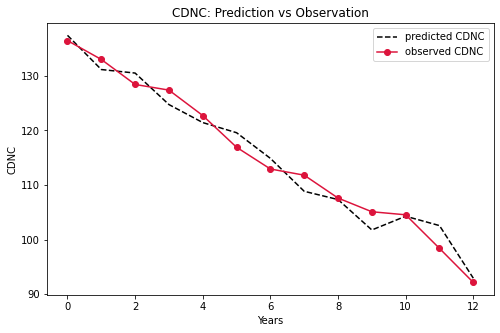

(0.9706124387638425,
 array([-343.85098,  207.5278 ,   32.03408,   58.67267,  216.31168,
        -147.8393 ], dtype=float32),
 547.1452)

In [ ]:
# Multi-linear regression for Annual value of CDCN and aerosol types
do_linear_reg(df)

In [ ]:
# Multi-linear regression for 13 years domain average of CDCN and aerosol types
bcarbon2 = np.log10(aerosol_bcarbon_mean)
dms2 = np.log10(aerosol_dms_mean)
dust2 = np.log10(aerosol_dust_mean)
ocarbon2 = np.log10(aerosol_ocarbon_mean)
sulphate2 = np.log10(aerosol_sulphate_mean)
seasalt2 = np.log10(aerosol_seasalt_mean)
cdnc2 = cdnc_mean

data2 = np.column_stack((bcarbon2, dms2, dust2, ocarbon2, sulphate2, seasalt2, cdnc2))
#df = pd.DataFrame(data)
df2 = pd.DataFrame(data2, columns = ['Bcarbon', 'DMS', 'Dust', 'Ocarbon', 'Sulphate', 'Seasalt', 'CDNC'])
df2.head()

,Bcarbon,DMS,Dust,Ocarbon,Sulphate,Seasalt,CDNC
0,-9.648561,-10.653005,-8.964499,-9.188501,-8.781478,-7.462587,177.847565
1,-9.577475,-10.420138,-8.669480,-9.113169,-8.660777,-7.514849,177.202698
2,-9.592013,-10.355135,-8.492626,-9.034901,-8.605968,-7.503851,122.040680
3,-9.619400,-10.167058,-8.226753,-8.993466,-8.638648,-7.515099,132.921524
4,-9.573505,-10.090090,-8.175522,-8.758180,-8.663976,-7.615856,113.852989


In [ ]:
df2.shape

(156, 7)

                            OLS Regression Results                            
Dep. Variable:                   CDNC   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     31.01
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           5.46e-24
Time:                        22:19:36   Log-Likelihood:                -641.70
No. Observations:                 156   AIC:                             1297.
Df Residuals:                     149   BIC:                             1319.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        308.7186    437.113      0.706      0.4

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


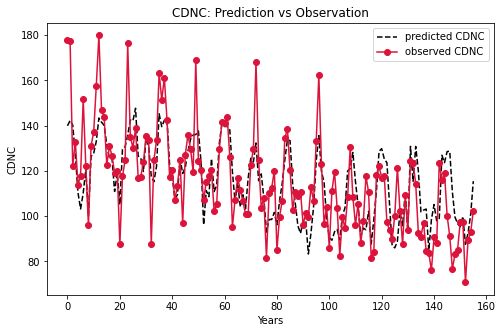

(0.5553394080050204,
 array([ 52.175137, -49.988075,  12.830116, -64.86789 ,  88.74691 ,
        -13.453661], dtype=float32),
 308.71823)

In [ ]:
# Multi-linear regression for 13 years domain average of CDCN and aerosol types
do_linear_reg(df2)

The inter-annual variation of the aerosol can help explain the trend of the CDNC at varying degree depending on the aerosol type as determined by the different coefficient of the multi-linear regression. The high positive correlation coefficient of 63.5% and 97.8%  and the p-values shows that the variation in the aerosols can explain the negative trend of CDNC over the 13 year period.

In [ ]:
np.array([1,2,3])

array([1, 2, 3])